## Political Orientation prediction of Reddit users: a supervised and unsupervised approach

As political polarization grows around the world (Gidron, Adams & Horne, 2019; Pew Research Center, 2017), social media platforms are progressively becoming more like arenas where individuals defend their own ideas and attack others (Tucker et al., 2018). In this research we test an approach to predict political orientation of social media users by using textual data shared on Reddit.
Our analysis is composed of the following steps: 

1. Collect users' posts through Reddit's public APIs (PRAW)
2. Manually annotate subreddits into Political/Non-Political. Political subreddits are then further labeled as either Conservatives or Democrats or Undecided.
3. Automatically assign a label (Conservative, Democrat, Undecided) to each user by:
    - computing label_score (score that consider the sum of upvotes received in each subreddit of the same label)
    - apply k-means clustering to assign a binary (Dem, Cons) categorical variable to each user through their parties' previously calculated label_score
4. For each user:
    - calculate the average of their moral foundation scores
    - visualizing the differences between Conservative, Democrat and Undecided labeled users (give me ideas for more visualizations idk what to do)
5. Test models

In [2]:
import pandas as pd

data = pd.read_csv("./data/scores.csv")
political_subreddits = pd.read_csv("./data/political_subreddits.csv")

In [3]:
data.head()

,username,title,selftext,subreddit,score,num_comments,posted_time,submission_type,fulltext,member_count,...,fairness.vice,fairness.virtue,care.virtue,care.vice,authority.virtue,authority.vice,loyalty.vice,loyalty.virtue,sanctity.vice,sanctity.virtue
0,laserfartt,NaN,"Yea nice cherry-picking, buddy. From the same ...",conservative,1,1228,2022-09-22 22:40:10,1,"Yea nice cherry-picking, buddy. From the same...",1154833.0,...,0.009555,0.000000,0.008689,0.000000,0.005353,0.000000,0.008673,0.000000,0.007771,0.000000
1,laserfartt,NaN,You stopped replying to our comment thread at ...,changemyview,3,93,2022-02-01 21:59:39,1,You stopped replying to our comment thread at...,3752107.0,...,0.015232,0.000000,0.000000,0.006923,0.000000,0.007148,0.000000,0.003127,0.002868,0.000000
2,laserfartt,NaN,> This is the problem with Rogan: he's all abo...,changemyview,1,93,2022-01-28 03:04:10,1,> This is the problem with Rogan: he's all ab...,3752107.0,...,0.000000,0.010639,0.011052,0.000000,0.009418,0.000000,0.000000,0.008146,0.000000,0.007464
3,laserfartt,NaN,If you have Spotify and are open to listen to ...,changemyview,1,93,2022-01-28 01:52:44,1,If you have Spotify and are open to listen to...,3752107.0,...,0.000000,0.006607,0.007421,0.000000,0.003766,0.000000,0.000000,0.005830,0.000000,0.006007
4,laserfartt,NaN,"> ""And he had an amazing point about civilizat...",changemyview,0,93,2022-01-28 01:08:44,1,"> ""And he had an amazing point about civiliza...",3752107.0,...,0.010256,0.000000,0.010847,0.000000,0.006819,0.000000,0.006856,0.000000,0.000000,0.006024


In [4]:
from data_collection.collector import DataCollector
import logging
import os 
import json
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

credentials_json = os.getenv('REDDIT_API_CREDENTIALS')
credentials = json.loads(credentials_json)[0]

def get_member_counts(subreddits):
    collector = DataCollector(**credentials)
    subreddits_members = []

    for idx, sub in subreddits.iterrows():
        try:
            member_count = collector.get_subreddit_member_count(sub.subreddit)
            subreddit = {"subreddit": sub.subreddit, "member_count": member_count, "label": sub.label }
            subreddits_members.append(subreddit)
        except Exception as e:
            print(f"{e}: {sub.subreddit}")

    return pd.DataFrame(subreddits_members)

subreddits_members = get_member_counts(political_subreddits)
subreddits_members.head()

Version 7.7.2.dev0 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


Redirect to /subreddits/search: moderatespolitics
received 403 HTTP response: liberals
received 404 HTTP response: progressivist
Redirect to /subreddits/search: commie_memes
Redirect to /subreddits/search: workersrevolt
Redirect to /subreddits/search: greenpeacedawn
received 403 HTTP response: progressiverevolution


,subreddit,member_count,label
0,conservative,1162352,c
1,askconservatives,24182,c
2,republican,207675,c
3,conservatives,108515,c
4,twoxconservatives,145,c


<!-- language of the users

0. annotate subreddits in terms of political views w many llms (claude, gpt, gemini) and assess quality of annotation (IAA inter annotator agreement)
1. get the member count for every subreddit - v 
2. compute karma/(subreddit member count) 
3. group by political label and see distributions of karma 
4. from step 3 distribution get the threshold using percentiles (of karma)
5. read random posts near threshold and qualitatvely estimate the political polarization 
6. adjust threshold and redo 5 till convergence
7. study the morality pattern of grouped by users and see the differences between two labels
    (explain whether the results replicate past research)
    7.5 check the time series
8. is the data good enough to make predictions of political orientation regardless of the theory given the collected post features (not our scores) -->


In [109]:
def filter_political_subreddits(df, df_political_subreddits):
    return df[df["subreddit"].isin(df_political_subreddits["subreddit"].to_list())]

def merge_subreddit_members(df, df_subreddit_members):
        df = df.copy()
        df = df.merge(right=df_subreddit_members, how="left", on=["subreddit"])
        df = df.drop(columns=[col for col in df.columns if col.endswith('_x')])
        df.columns = [col.replace('_y', '') for col in df.columns]
        df["member_count"] = df["member_count"].fillna(df["member_count"].mean())
        df["label"] = df["label"].fillna("-")
    
        return df

In [110]:
filtered_data = filter_political_subreddits(data, political_subreddits)
filtered_data = merge_subreddit_members(filtered_data, subreddits_members)

In [111]:
from scipy.stats import skew

def calculate_skewness(data, feature_name):
    """
    Calculate the skewness of a given feature.
    
    Parameters:
        data (pd.Series): The data for which to calculate skewness.
        feature_name (str): The name of the feature (for display purposes).
    
    Returns:
        float: Skewness value.
    """
    skewness_value = skew(data, bias=False) 
    print(f"Skewness of {feature_name}: {skewness_value:.4f}")
    return skewness_value

skew_score = calculate_skewness(filtered_data["score"], "Score")

Skewness of Score: 141.8309


# Mathematical Explanation of Data Transformations

Given a dataset represented as a DataFrame \( df \), the following transformations are applied:


In [112]:
import numpy as np

def make_positive(column):
    min_value = column.min()
    return (column - min_value) + 1 if min_value < 0 else column

def log_transform(column):
    return np.log(make_positive(column))

def log_transform_data(df):
    df = df.copy() 

    df["score"] = df["score"]
    df['member_count'] = df["member_count"]

    df["avg_user_subreddit_karma"] = df.groupby(by=["username", "subreddit"])["score"].transform("median")
    df["avg_user_subreddit_karma"] = log_transform(df["avg_user_subreddit_karma"]) + 1
    
    df["avg_user_subreddit_karma_per_member_count"] = (df["avg_user_subreddit_karma"] / (df["member_count"])) + 1 
    df["avg_user_subreddit_karma_per_member_count"] = log_transform(df["avg_user_subreddit_karma_per_member_count"]) + 1

    df["label_score"] = df.groupby(by=["label", "username"])["avg_user_subreddit_karma_per_member_count"].transform("sum")
    df["label_score"] = log_transform(df["label_score"])

    return df

def transform_data(df):
    df = df.copy() 

    df["avg_user_subreddit_karma"] = df.groupby(by=["username", "subreddit"])["score"].transform("median")
    df["avg_user_subreddit_karma_per_member_count"] = (df["avg_user_subreddit_karma"] / (df["member_count"])) + 1 
    df["label_score"] = df.groupby(by=["label", "username"])["avg_user_subreddit_karma_per_member_count"].transform("sum")

    return df

In [113]:
log_transformed_data = log_transform_data(filtered_data)
transformed_data = transform_data(filtered_data)

Average of the karma distribution per each label looks similar in subreddits of both political labels.
This result suggests that user's of both subreddits group have similar upvote behaviours. With democrats showing a higher average.
The distribution is skewed in both groups, suggesting a high influence of very popular submissions.
It is also possible to notice differences in left tails in both groups.
In fact, democrats left tail suggest that posts on liberal subreddits tend to receive far more downvotes then conservatives ones.
In general, democrats subreddits appear to have a higher variability. This can be due to lower general member counts between the two groups as show in the earlier plots.

In [114]:
import pandas as pd

def add_party_scores(data: pd.DataFrame, value: str, log: bool = False) -> pd.DataFrame:
    """
    Processes the transformed data by performing pivoting, normalization, and merging.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing 'username', 'label', and 'label_score'.

    Returns:
        pd.DataFrame: The updated DataFrame after processing.
    """

    data = data.copy()
    
    pivoted = data.pivot_table(
        index=["username"], 
        columns="label", 
        values=value, 
        fill_value=0
    ).reset_index()

    for col in ["c", "d"]:
        pivoted[col] = (pivoted[col] - pivoted[col].mean()) / pivoted[col].std()

    pivoted["c_d"] = pivoted["c"] - pivoted["d"]
    pivoted = pivoted.fillna(1)

    result = data.merge(right=pivoted, on="username", how="left")
    
    return result

log_transformed_data_pivoted = add_party_scores(log_transformed_data, "label_score", log=True)
transformed_data_pivoted = add_party_scores(transformed_data, "label_score")

In [115]:
def aggregate_data(df):
    grouped = df.groupby(['username']).agg({
        'bias_fairness': 'mean',
        'bias_care': 'mean',
        'bias_authority': 'mean',
        'bias_loyalty': 'mean',
        'bias_sanctity': 'mean',
        'intensity_fairness': 'mean',
        'intensity_care': 'mean',
        'intensity_authority': 'mean',
        'intensity_loyalty': 'mean',
        'intensity_sanctity': 'mean', 
        'fairness.vice': 'mean',
        'fairness.virtue': 'mean', 
        'care.virtue': 'mean', 
        'care.vice': 'mean', 
        'authority.virtue': 'mean',
        'authority.vice': 'mean', 
        'loyalty.vice': 'mean', 
        'loyalty.virtue': 'mean', 
        'sanctity.vice': 'mean',
        'sanctity.virtue': 'mean',
        'c': lambda x: x.mode()[0],
        'd': lambda x: x.mode()[0]
    }).reset_index()

    return grouped

grouped = aggregate_data(transformed_data_pivoted)
log_grouped = aggregate_data(log_transformed_data_pivoted)

Running an isolation forest with $n = 100$ estimation reported 21697 anomalies in both $c$ and $d$ scores (i.e. respectively upvotes received in Conservative and Democrats subreddits). By inspecting some of the more extreme cases it can be shown that a high amount of upvotes does not necessarily indicate a strongly polarized ideological content but rather a news that caused a stir on the social media platform.


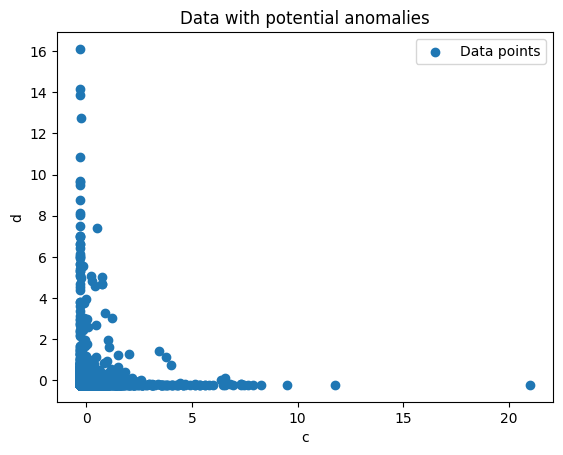

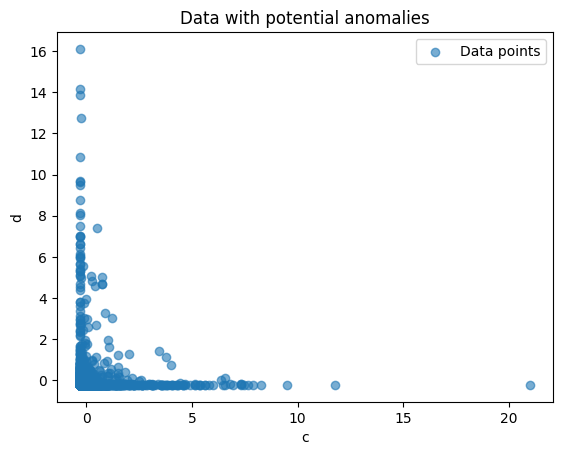

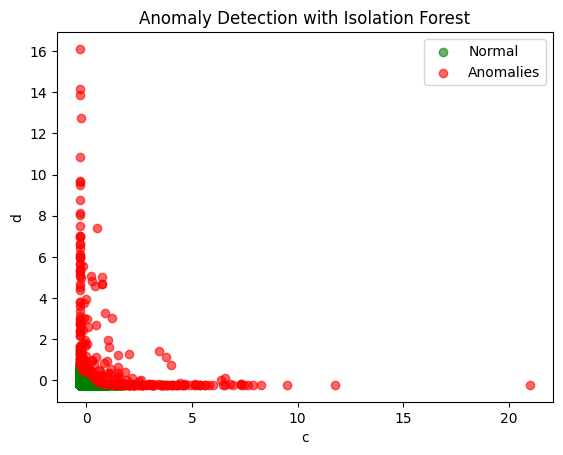

Number of anomalies detected: 286


In [116]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

plt.scatter(grouped['c'], grouped['d'], label='Data points')
plt.title('Data with potential anomalies')
plt.xlabel('c')
plt.ylabel('d')
plt.legend()
plt.show()

isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
grouped['anomaly_score'] = isolation_forest.fit_predict(grouped[['c', 'd']])

grouped['is_anomaly'] = grouped['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

normal_points = grouped[grouped['is_anomaly'] == 0]
anomalous_points = grouped[grouped['is_anomaly'] == 1]

plt.scatter(grouped['c'], grouped['d'], alpha=0.6, label='Data points')
plt.title('Data with potential anomalies')
plt.xlabel('c')
plt.ylabel('d')
plt.legend()
plt.show()

plt.scatter(normal_points['c'], normal_points['d'], c='green', alpha=0.6, label='Normal')
plt.scatter(anomalous_points['c'], anomalous_points['d'], c='red', alpha=0.6, label='Anomalies')
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('c')
plt.ylabel('d')
plt.legend()
plt.show()

print("Number of anomalies detected:", anomalous_points.shape[0])


In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

def violin_plot(df: pd.DataFrame, values: list, ylab: str = "Score", title=""):
    df_melted = df[values].melt(var_name="Variable", value_name="Score")

    sns.violinplot(data=df_melted, x="Variable", y="Score")
    plt.title(f"Comparison of Political Belief Scores {title}")
    plt.xlabel("Political Belief Scores")
    plt.ylabel(ylab)
    plt.show()


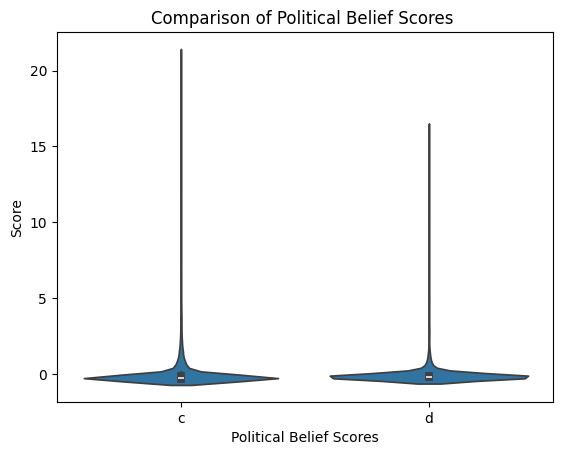

In [118]:
violin_plot(grouped, ["c", "d"])

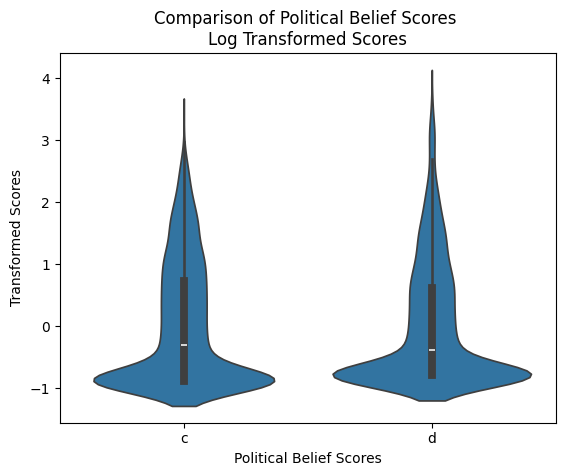

In [119]:
violin_plot(log_grouped, ["c", "d"], ylab="Transformed Scores", title="\nLog Transformed Scores")

In [120]:
grouped.shape

(2853, 25)

In [121]:
grouped[["username", "c", "d"]].max()

username        zy_89
c           21.026262
d           16.114807
dtype: object

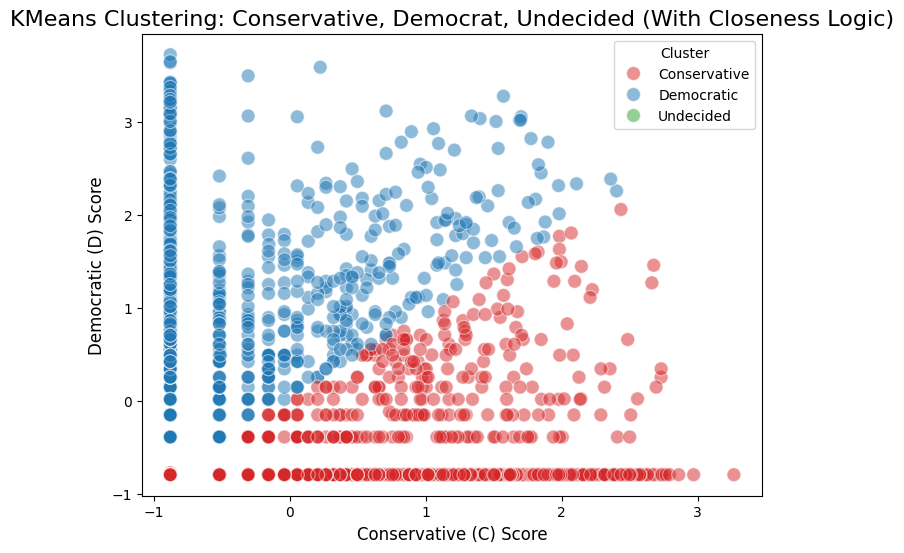

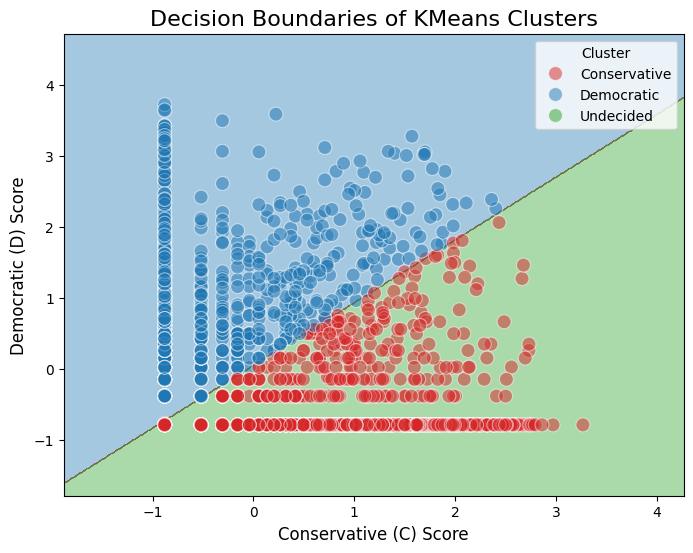

In [129]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

COLOR_PALETTE = {
    "Conservative": "#d62728",  # Red for conservatives
    "Democratic": "#1f77b4",    # Blue for democrats
    "Undecided": "#2ca02c"      # Green for undecided
}

def preprocess_data(data, features):
    """Standardize the features in the dataset."""
    scaler = StandardScaler()
    return scaler.fit_transform(data[features])

def perform_kmeans_clustering(X, n_clusters=3):
    """Perform KMeans clustering and return labels and centroids."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    return labels, centroids

def assign_clusters_with_penalty(X, centroids, proximity_threshold):
    """Assign clusters with penalty for proximity to decision boundaries."""
    distances_to_centroids = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels_with_penalty = []

    for i, point in enumerate(X):
        distance_to_conservative = distances_to_centroids[i, conservative_cluster]
        distance_to_democratic = distances_to_centroids[i, democratic_cluster]

        if distance_to_conservative < proximity_threshold and distance_to_democratic < proximity_threshold:
            labels_with_penalty.append(undecided_cluster)
        elif distance_to_conservative < distance_to_democratic:
            labels_with_penalty.append(conservative_cluster)
        else:
            labels_with_penalty.append(democratic_cluster)

    return labels_with_penalty

def map_cluster_labels(labels, cluster_labels):
    """Map numeric cluster labels to descriptive labels."""
    return [cluster_labels[label] for label in labels]

def plot_data_with_clusters(data, x_feature, y_feature, cluster_col, palette, title):
    """Plot scatter plot of data with clusters."""
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x=x_feature,
        y=y_feature,
        hue=cluster_col,
        palette=palette,
        s=100,
        alpha=0.5,  # Reduced alpha for transparency
        hue_order=["Conservative", "Democratic", "Undecided"]
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Conservative (C) Score", fontsize=12)
    plt.ylabel("Democratic (D) Score", fontsize=12)
    plt.legend(title="Cluster", loc='best')
    plt.show()

def plot_decision_boundaries(xx, yy, penalty_labels, custom_cmap, data, x_feature, y_feature, cluster_col, palette):
    """Plot decision boundaries with penalty logic."""
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, penalty_labels, alpha=0.4, cmap=custom_cmap)
    sns.scatterplot(
        data=data,
        x=x_feature,
        y=y_feature,
        hue=cluster_col,
        palette=palette,
        s=100,
        alpha=0.5,  # Reduced alpha for transparency
        hue_order=["Conservative", "Democratic", "Undecided"]
    )
    plt.title("Decision Boundaries of KMeans Clusters", fontsize=16)
    plt.xlabel("Conservative (C) Score", fontsize=12)
    plt.ylabel("Democratic (D) Score", fontsize=12)
    plt.legend(title="Cluster", loc='best')
    plt.show()

def detect_parties(data, proximity_threshold=1.5, plot_data=False):
    """Process data through clustering and visualization pipeline."""
    def plot(data):
        plot_data_with_clusters(
            data, "c", "d", "party", COLOR_PALETTE,
            "KMeans Clustering: Conservative, Democrat, Undecided (With Closeness Logic)"
        )

        # Generate mesh grid for decision boundaries
        x_min, x_max = data['c'].min() - 1, data['c'].max() + 1
        y_min, y_max = data['d'].min() - 1, data['d'].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

        # Apply penalty logic to classify grid points
        penalty_labels = []
        for point in np.c_[xx.ravel(), yy.ravel()]:
            distances = np.linalg.norm(point - centroids, axis=1)
            distance_to_conservative = distances[conservative_cluster]
            distance_to_democratic = distances[democratic_cluster]

            if distance_to_conservative < proximity_threshold and distance_to_democratic < proximity_threshold:
                penalty_labels.append(undecided_cluster)
            elif distance_to_conservative < distance_to_democratic:
                penalty_labels.append(conservative_cluster)
            else:
                penalty_labels.append(democratic_cluster)

        penalty_labels = np.array(penalty_labels).reshape(xx.shape)
        custom_cmap = ListedColormap(["#1f77b4", "#d62728", "#2ca02c"])  # Order changed to match color palette

        # Plot decision boundaries
        plot_decision_boundaries(xx, yy, penalty_labels, custom_cmap, data, "c", "d", "party", COLOR_PALETTE)

    X = preprocess_data(data, ["c", "d"])
    labels, centroids = perform_kmeans_clustering(X)

    # Calculate score differences
    score_differences = centroids[:, 0] - centroids[:, 1]
    global conservative_cluster, democratic_cluster, undecided_cluster
    undecided_cluster = np.argmin(np.abs(score_differences))
    conservative_cluster = np.argmax(score_differences)
    democratic_cluster = 3 - undecided_cluster - conservative_cluster

    # Map numeric clusters to descriptive labels
    cluster_labels = {
        conservative_cluster: "Conservative",
        democratic_cluster: "Democratic",
        undecided_cluster: "Undecided"
    }

    # Assign clusters with penalty logic
    labels_with_penalty = assign_clusters_with_penalty(X, centroids, proximity_threshold)

    # Map clusters to descriptive labels
    data['party'] = map_cluster_labels(labels_with_penalty, cluster_labels)

    if plot_data:
        plot(data)

    return data

# Apply process to both datasets
log_grouped = detect_parties(log_grouped, 1, plot_data=True)

In [123]:
grouped.shape

(2853, 26)

In [124]:
log_grouped[log_grouped["username"]=="laserfartt"]["party"]

1378    Conservative
Name: party, dtype: object

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19040\1635857829.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


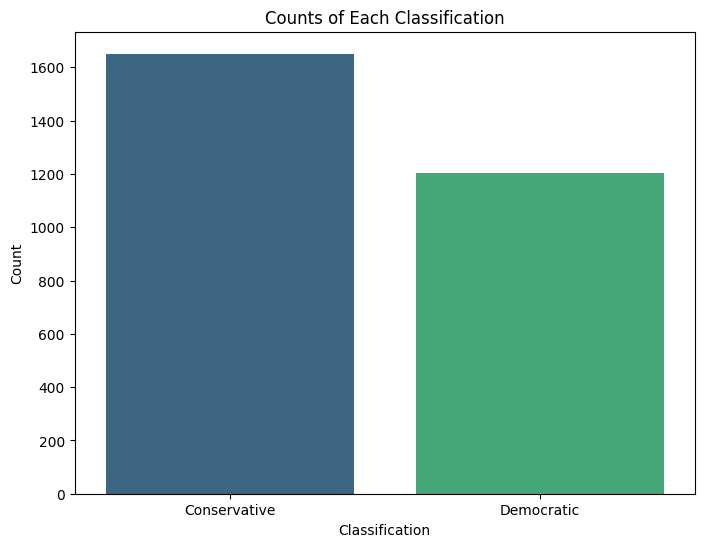

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_classification_counts(data, column_name):
    """
    Plots the counts of each classification in the specified column of the data.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing the classification column.
        column_name (str): The name of the column to count and plot.
    """
    # Get value counts for the specified column
    class_counts = data[column_name].value_counts()

    # Plot the counts for each classification
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

    plt.xlabel('Classification')
    plt.ylabel('Count')
    plt.title('Counts of Each Classification')

    plt.show()

plot_classification_counts(log_grouped, 'party')



todo: 
1. which karma threshold (help us annotate users as cons or liberal) by looking at the distribution of the subreddit
2. visualizations (studying distribution of karma [see 1.], distribution of intensity, bias between the groups)
    
    - boxplots
    - qq-plots
    - pca/tsne
    - distribution of target (barplot)
    - time series nearby elections data
    - data quality (missing values, duplicates)

3. linking the methods to the topics



In [131]:
def aggregate_data(df):
    grouped = df.groupby(['username']).agg({
        'bias_fairness': 'mean',
        'bias_care': 'mean',
        'bias_authority': 'mean',
        'bias_loyalty': 'mean',
        'bias_sanctity': 'mean',
        'intensity_fairness': 'mean',
        'intensity_care': 'mean',
        'intensity_authority': 'mean',
        'intensity_loyalty': 'mean',
        'intensity_sanctity': 'mean', 
        'fairness.vice': 'mean',
        'fairness.virtue': 'mean', 
        'care.virtue': 'mean', 
        'care.vice': 'mean', 
        'authority.virtue': 'mean',
        'authority.vice': 'mean', 
        'loyalty.vice': 'mean', 
        'loyalty.virtue': 'mean', 
        'sanctity.vice': 'mean',
        'sanctity.virtue': 'mean',
        'party': lambda x: x.mode()[0]
    }).reset_index()

    return grouped

In [132]:
log_transformed_data_pivoted.columns

Index(['username', 'title', 'selftext', 'subreddit', 'score', 'num_comments',
       'posted_time', 'submission_type', 'fulltext', 'bias_fairness',
       'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity',
       'intensity_fairness', 'intensity_care', 'intensity_authority',
       'intensity_loyalty', 'intensity_sanctity', 'fairness.vice',
       'fairness.virtue', 'care.virtue', 'care.vice', 'authority.virtue',
       'authority.vice', 'loyalty.vice', 'loyalty.virtue', 'sanctity.vice',
       'sanctity.virtue', 'member_count', 'label', 'avg_user_subreddit_karma',
       'avg_user_subreddit_karma_per_member_count', 'label_score', 'c', 'd',
       'c_d'],
      dtype='object')

Unique quarters after grouping: <PeriodArray>
['2008Q4', '2009Q3', '2009Q4', '2010Q1', '2010Q2', '2010Q3', '2010Q4',
 '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3',
 '2012Q4', '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
 '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1',
 '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
 '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3',
 '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2',
 '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1',
 '2023Q2', '2023Q3', '2023Q4', '2024Q1', '2024Q2', '2024Q3', '2024Q4']
Length: 63, dtype: period[Q-DEC]


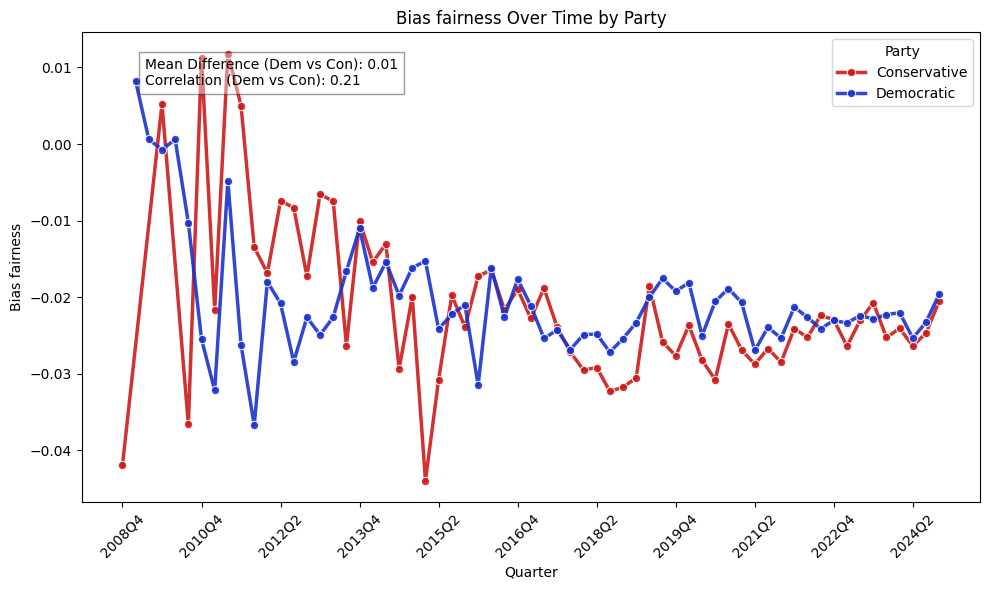

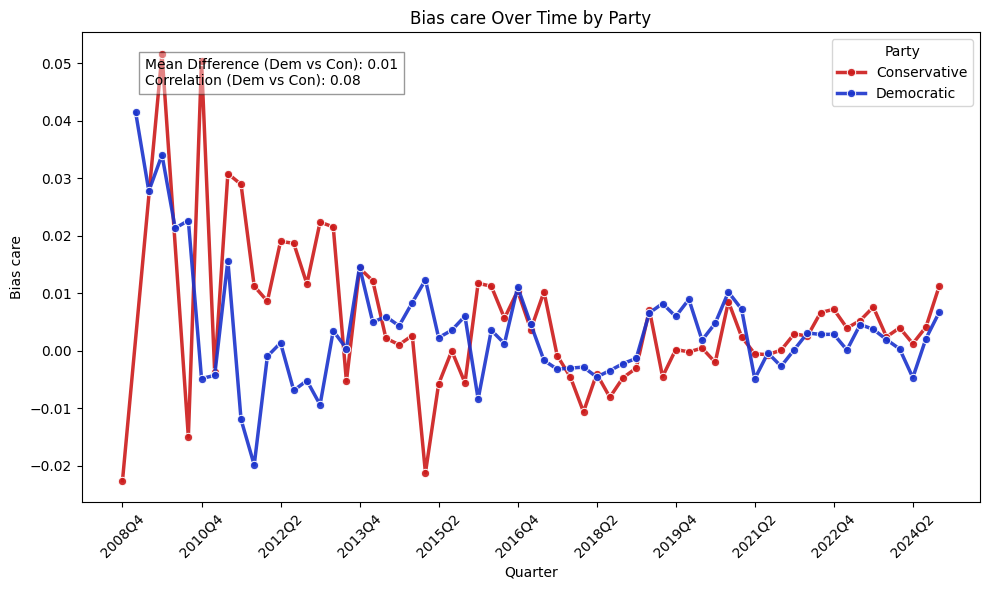

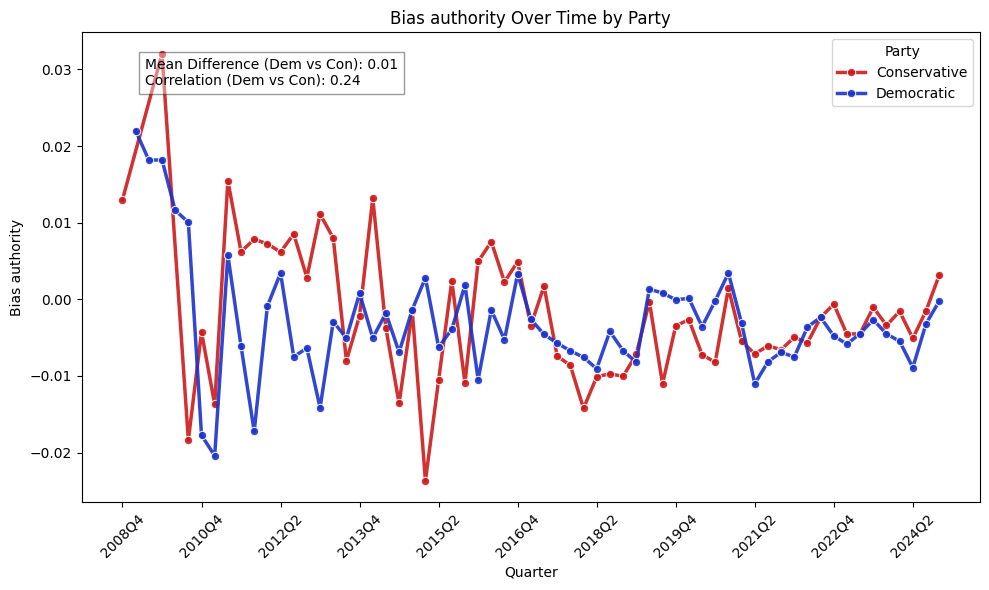

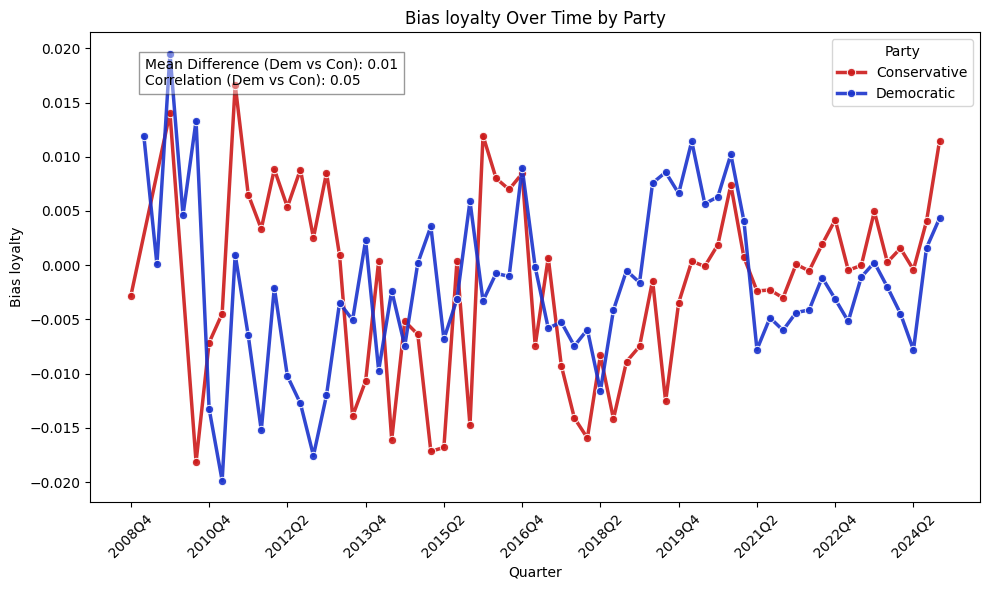

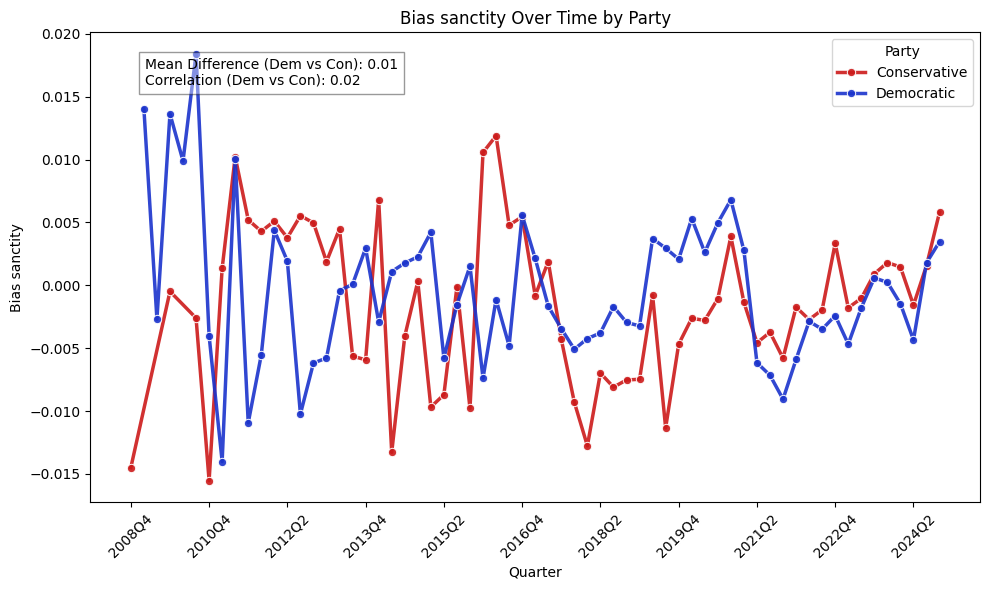

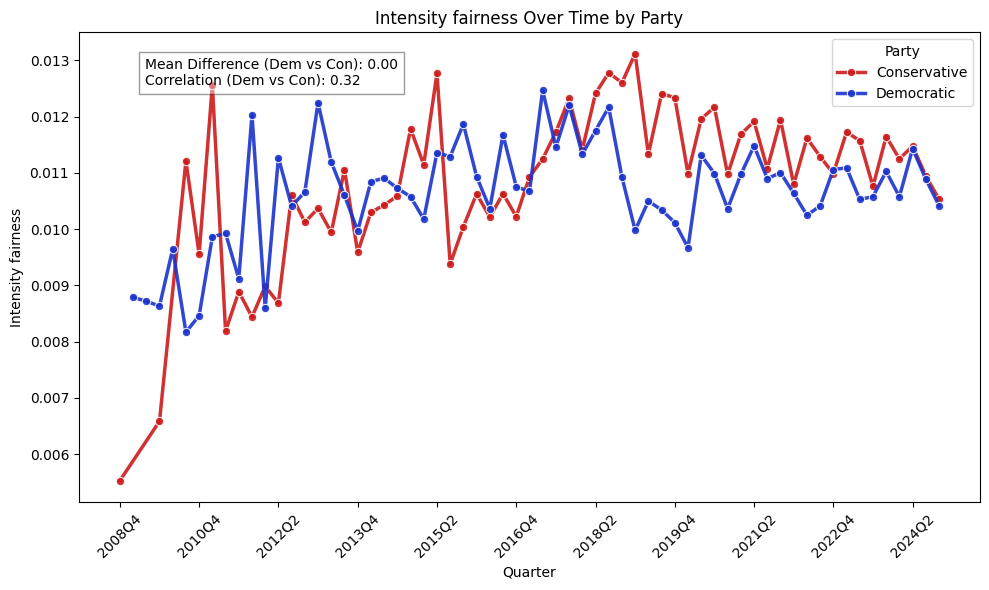

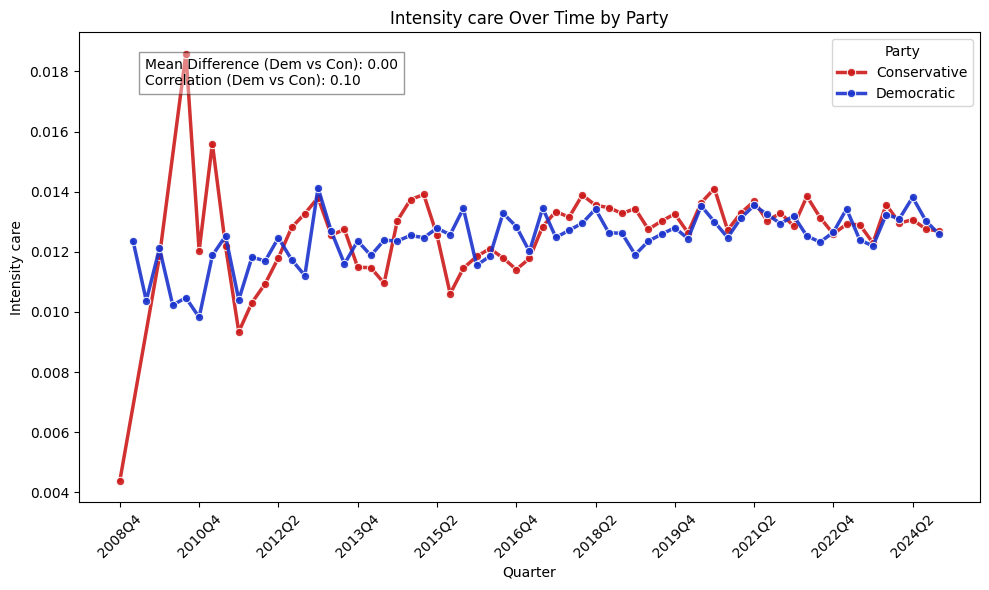

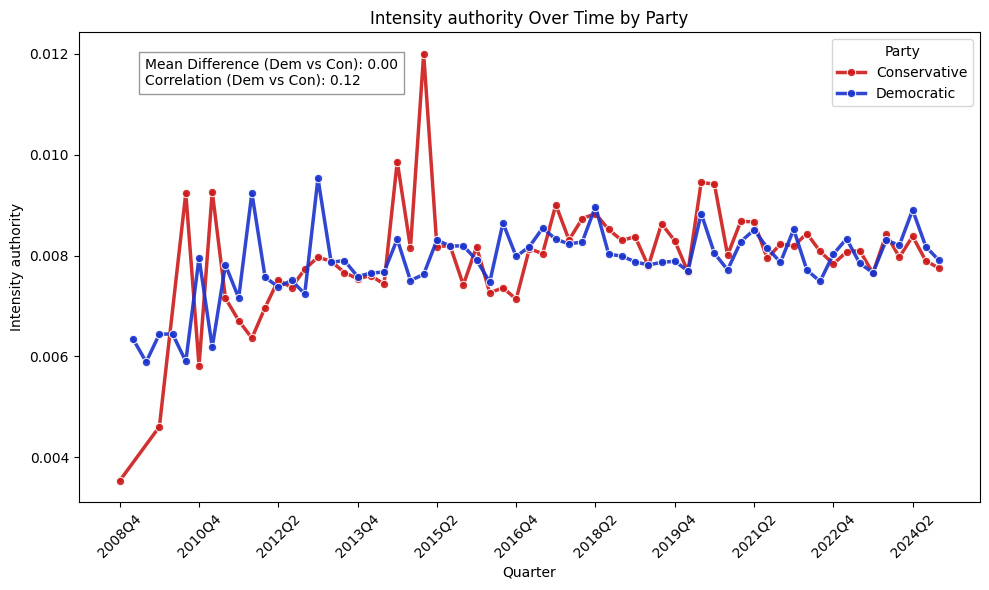

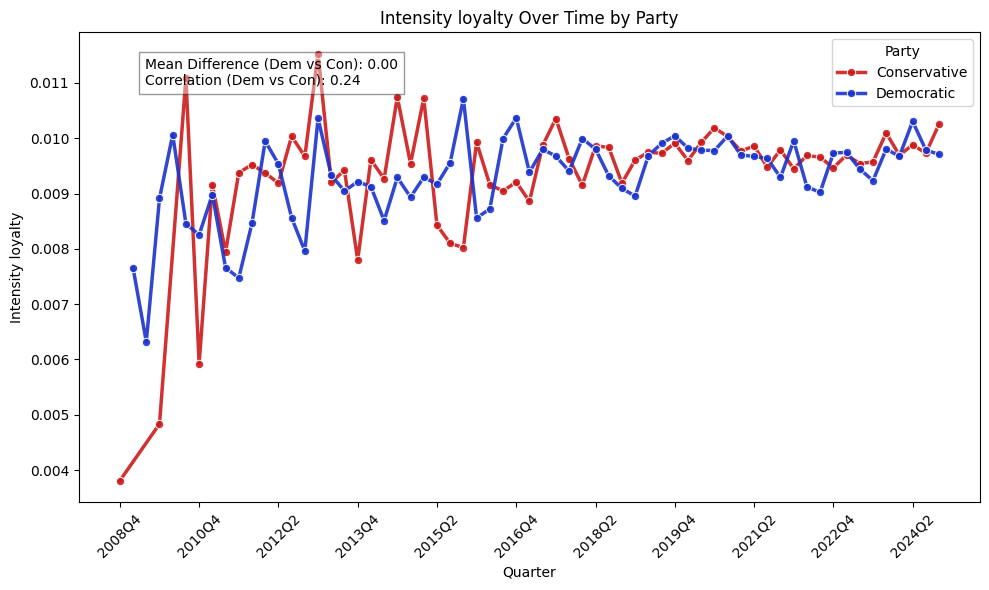

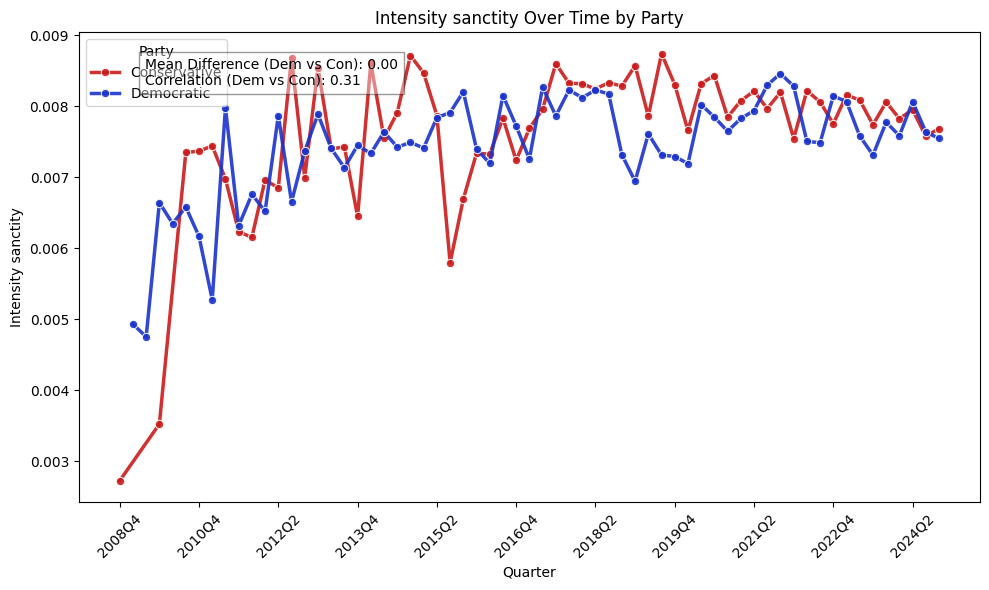

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

log_transformed_data_pivoted['posted_time'] = pd.to_datetime(log_transformed_data_pivoted['posted_time'])
log_transformed_data_pivoted = log_transformed_data_pivoted.merge(right=log_grouped[["username", "party"]], on="username", how="left")

log_transformed_data_pivoted['quarter'] = log_transformed_data_pivoted['posted_time'].dt.to_period('Q')

grouped = log_transformed_data_pivoted.groupby(['quarter', 'party']).agg({
    'bias_fairness': 'mean',
    'bias_care': 'mean',
    'bias_authority': 'mean',
    'bias_loyalty': 'mean',
    'bias_sanctity': 'mean',
    'intensity_fairness': 'mean',
    'intensity_care': 'mean',
    'intensity_authority': 'mean',
    'intensity_loyalty': 'mean',
    'intensity_sanctity': 'mean',
}).reset_index()

print("Unique quarters after grouping:", grouped['quarter'].unique())

grouped['quarter'] = grouped['quarter'].astype(str)

# Define party colors with a lighter, less intense 'Undecided'
party_colors = {
    'Democratic': (0.1, 0.2, 0.8, 0.9),  # Bright blue for Democrats
    'Conservative': (0.8, 0.1, 0.1, 0.9),  # Bright red for Conservatives
    'Undecided': (0.6, 0.9, 0.6, 0.3),  # Light green with low intensity
}

def calculate_metrics(df, dimension):
    # Pivot data for comparison
    pivot = df.pivot(index='quarter', columns='party', values=dimension)
    
    # Ensure both Democratic and Conservative are present
    if 'Democratic' in pivot.columns and 'Conservative' in pivot.columns:
        # Mean absolute difference
        mean_diff = (pivot['Democratic'] - pivot['Conservative']).abs().mean()
        
        # Correlation
        valid_data = pivot[['Democratic', 'Conservative']].dropna()
        correlation = pearsonr(valid_data['Democratic'], valid_data['Conservative'])[0]
    else:
        mean_diff = None
        correlation = None
    
    return mean_diff, correlation

# Plotting function with metrics
def plot_dimensions(dimensions, title_prefix):
    for dimension in dimensions:
        # Calculate metrics
        mean_difference, correlation = calculate_metrics(grouped, dimension)
        
        # Plot
        plt.figure(figsize=(10, 6))
        g = sns.lineplot(
            data=grouped, 
            x='quarter', 
            y=dimension, 
            hue='party', 
            palette=party_colors, 
            alpha=0.9, 
            linewidth=2.5, 
            marker='o'
        )
        g.set(
            title=f'{dimension.replace("_", " ").capitalize()} Over Time by Party',
            xlabel='Quarter',
            ylabel=dimension.replace("_", " ").capitalize()
        )
        
        # Customize x-axis ticks
        tick_labels = grouped['quarter'].unique()
        tick_indices = list(range(0, len(tick_labels), max(1, len(tick_labels) // 10)))  # Approx 10 labels
        plt.xticks(tick_indices, [tick_labels[i] for i in tick_indices], rotation=45)
        
        plt.legend(title='Party')
        plt.tight_layout()

        # Add metrics as text on the graph
        metrics_text = (
            f"Mean Difference (Dem vs Con): {mean_difference:.2f}\n"
            f"Correlation (Dem vs Con): {correlation:.2f}"
            if mean_difference is not None and correlation is not None
            else "Metrics unavailable"
        )
        plt.gcf().text(0.15, 0.85, metrics_text, fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.4))

        plt.show()

# Bias dimensions
bias_dimensions = ['bias_fairness', 'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity']
plot_dimensions(bias_dimensions, "Bias")

# Intensity dimensions
intensity_dimensions = ['intensity_fairness', 'intensity_care', 'intensity_authority', 'intensity_loyalty', 'intensity_sanctity']
plot_dimensions(intensity_dimensions, "Intensity")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

bias_dimensions = ['bias_fairness', 'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity']
intensity_dimensions = ['intensity_fairness', 'intensity_care', 'intensity_authority', 'intensity_loyalty', 'intensity_sanctity']

party_colors = {
    'Democratic': 'blue',
    'Conservative': 'red',
    'Undecided': 'green'
}

# Violin plots for bias dimensions
for dimension in bias_dimensions:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=grouped, x='party', y=dimension, palette=party_colors, inner="quartile")
    plt.title(f'Distribution of {dimension.replace("_", " ").capitalize()} by Party')
    plt.xlabel('Party')
    plt.ylabel(dimension.replace("_", " ").capitalize())
    
    # Manually create legend handles
    legend_labels = ['Democratic', 'Conservative', 'Undecided']
    legend_colors = [party_colors[label] for label in legend_labels if label in grouped['party'].unique()]
    legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    
    # Set the custom legend
    plt.legend(handles=legend_handles, title='Party', loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Violin plots for intensity dimensions
for dimension in intensity_dimensions:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=grouped, x='party', y=dimension, palette=party_colors, inner="quartile")
    plt.title(f'Distribution of {dimension.replace("_", " ").capitalize()} by Party')
    plt.xlabel('Party')
    plt.ylabel(dimension.replace("_", " ").capitalize())
    
    # Manually create legend handles
    legend_labels = ['Democratic', 'Conservative', 'Undecided']
    legend_colors = [party_colors[label] for label in legend_labels if label in grouped['party'].unique()]
    legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    
    # Set the custom legend
    plt.legend(handles=legend_handles, title='Party', loc='upper right')
    
    plt.tight_layout()
    plt.show()


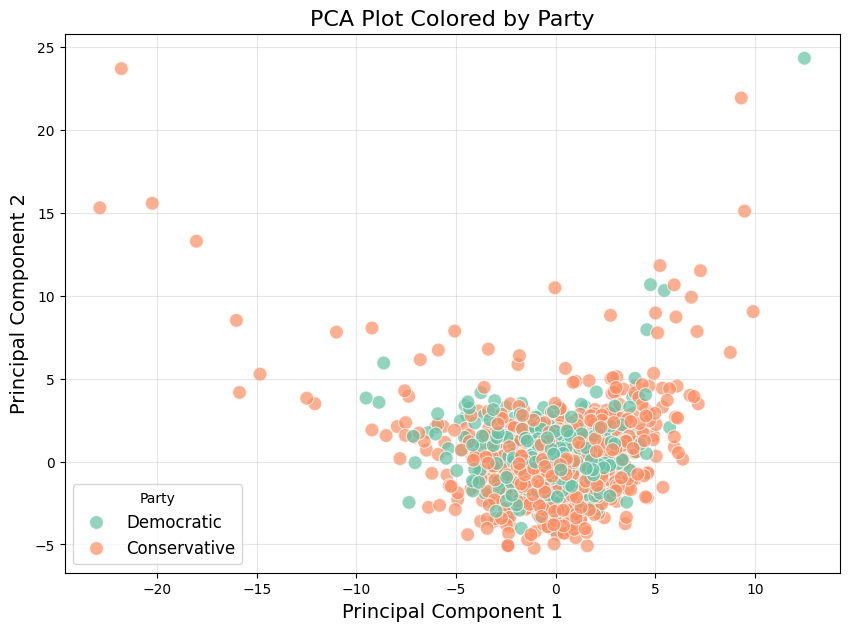

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

features = [
    'bias_fairness', 'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity',
    'intensity_fairness', 'intensity_care', 'intensity_authority', 'intensity_loyalty', 'intensity_sanctity'
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(log_grouped[features])

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['party'] = log_grouped['party']
pca_df['username'] = log_grouped['username']

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', hue='party', data=pca_df, palette='Set2', s=100, alpha=0.7
)

plt.title('PCA Plot Colored by Party', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Party', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

def models(df): 
    df = df.copy()

    X = df.drop(columns=['party'])  
    y = df['party']  

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Define numeric features for preprocessing
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='mean'),  # Handle missing values
        StandardScaler()  # Scale the numeric features
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ]
    )

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(probability=True),
        'Naive Bayes': GaussianNB()
    }

    # Function to train and evaluate models
    def evaluate_models(X_train, X_test):
        results = []

        plt.figure(figsize=(10, 8))  # Initialize the plot for ROC curves
        plt.title('ROC Curve')

        for model_name, model in models.items():
            print(f"Training {model_name}...")

            # Create a pipeline with preprocessing and the model
            pipeline = make_pipeline(preprocessor, model)

            # Cross-validation to evaluate model performance
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
            cv_mean_score = cv_scores.mean()

            # Train the model
            pipeline.fit(X_train, y_train)

            # Predictions
            y_pred = pipeline.predict(X_test)
            y_prob = pipeline.predict_proba(X_test)  # Probabilities for ROC curve

            # Model evaluation
            classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
            confusion_mat = confusion_matrix(y_test, y_pred)

            # Collect results in a structured way
            results.append({
                'Model': model_name,
                'CV Accuracy Mean': cv_mean_score,
                'Test Accuracy': (y_pred == y_test).mean(),
                'Classification Report': classification_rep,
                'Confusion Matrix': confusion_mat
            })

            print(f"Cross-validation accuracy: {cv_mean_score:.4f}")
            print(f"Test accuracy for {model_name}: {(y_pred == y_test).mean():.4f}")
            print('-' * 60)

            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)  # For binary classification
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve for this model
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        # Finalize ROC curve
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

        # Plot Precision, Recall, Accuracy for all models
        metrics_df = pd.DataFrame({
            'Model': [result['Model'] for result in results],
            'Accuracy': [result['Test Accuracy'] for result in results],
            'Precision': [result['Classification Report']['weighted avg']['precision'] for result in results],
            'Recall': [result['Classification Report']['weighted avg']['recall'] for result in results]
        })

        metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6), rot=45, grid=True)
        plt.title('Model Comparison by Accuracy, Precision, Recall')
        plt.ylabel('Score')
        plt.show()

        return pd.DataFrame(results)

    # Evaluate on the dataset
    results = evaluate_models(X_train, X_test)

Training Logistic Regression...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5666
Test accuracy for Logistic Regression: 0.5744
------------------------------------------------------------
Training Random Forest...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5592
Test accuracy for Random Forest: 0.6182
------------------------------------------------------------
Training Gradient Boosting...
Cross-validation accuracy: 0.5508
Test accuracy for Gradient Boosting: 0.5814
------------------------------------------------------------
Training LDA...
Cross-validation accuracy: 0.5675
Test accuracy for LDA: 0.5727
------------------------------------------------------------
Training QDA...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

Cross-validation accuracy: 0.4562
Test accuracy for QDA: 0.4046
------------------------------------------------------------
Training KNN...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5346
Test accuracy for KNN: 0.5552
------------------------------------------------------------
Training SVM...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5741
Test accuracy for SVM: 0.5797
------------------------------------------------------------
Training Naive Bayes...
Cross-validation accuracy: 0.2984
Test accuracy for Naive Bayes: 0.2995
------------------------------------------------------------


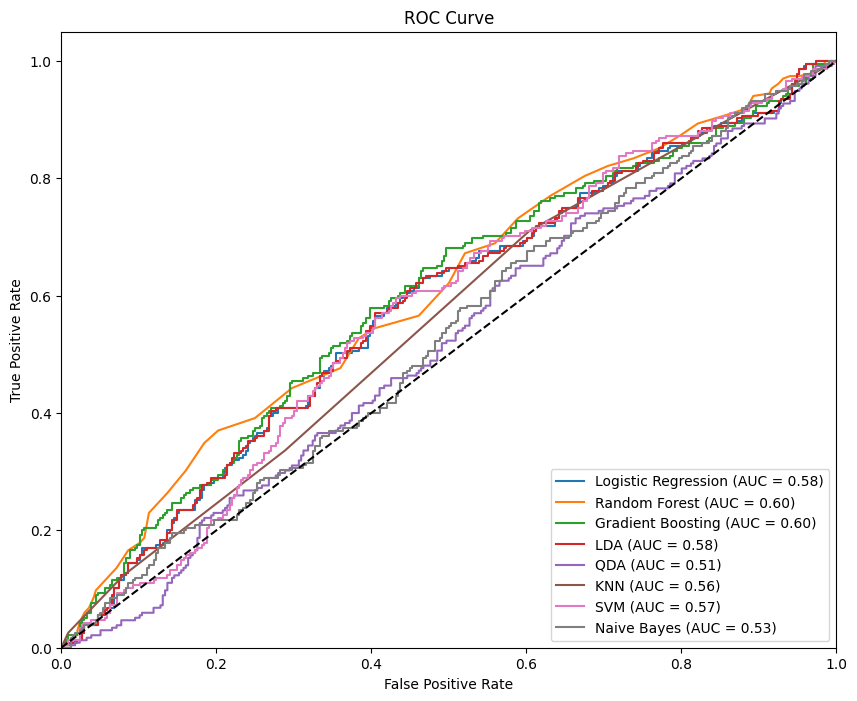

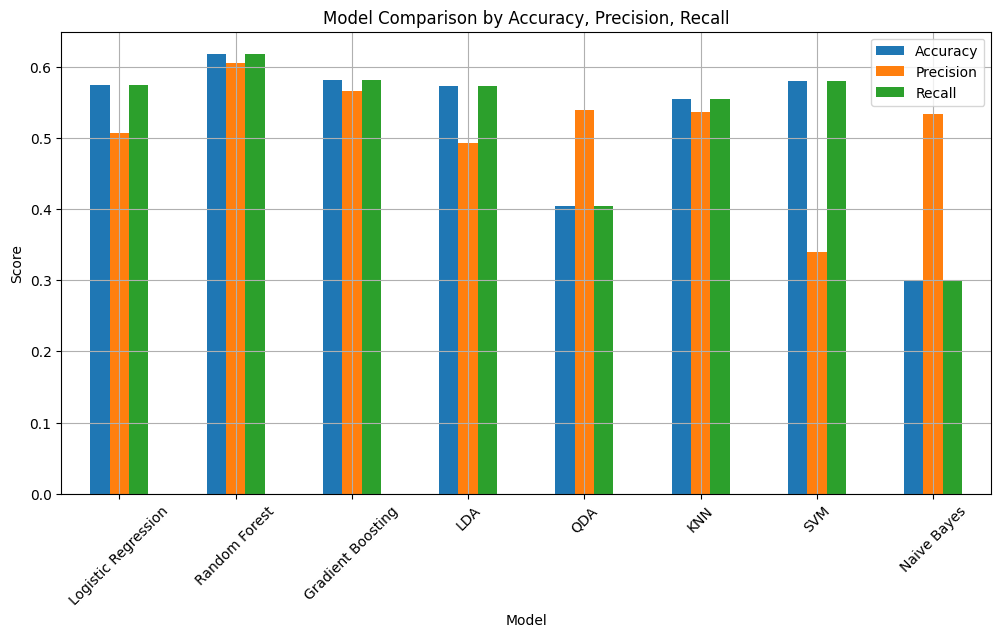

In [ ]:
models(log_grouped)

Training Logistic Regression...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.8904
Test accuracy for Logistic Regression: 0.8949
------------------------------------------------------------
Training Random Forest...
Cross-validation accuracy: 0.8940
Test accuracy for Random Forest: 0.8984
------------------------------------------------------------
Training Gradient Boosting...
Cross-validation accuracy: 0.8887
Test accuracy for Gradient Boosting: 0.8967
------------------------------------------------------------
Training LDA...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

Cross-validation accuracy: 0.8904
Test accuracy for LDA: 0.8949
------------------------------------------------------------
Training QDA...
Cross-validation accuracy: 0.8046
Test accuracy for QDA: 0.7916
------------------------------------------------------------
Training KNN...
Cross-validation accuracy: 0.8348
Test accuracy for KNN: 0.8511
------------------------------------------------------------
Training SVM...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.8904
Test accuracy for SVM: 0.8949
------------------------------------------------------------
Training Naive Bayes...
Cross-validation accuracy: 0.6582
Test accuracy for Naive Bayes: 0.6637
------------------------------------------------------------


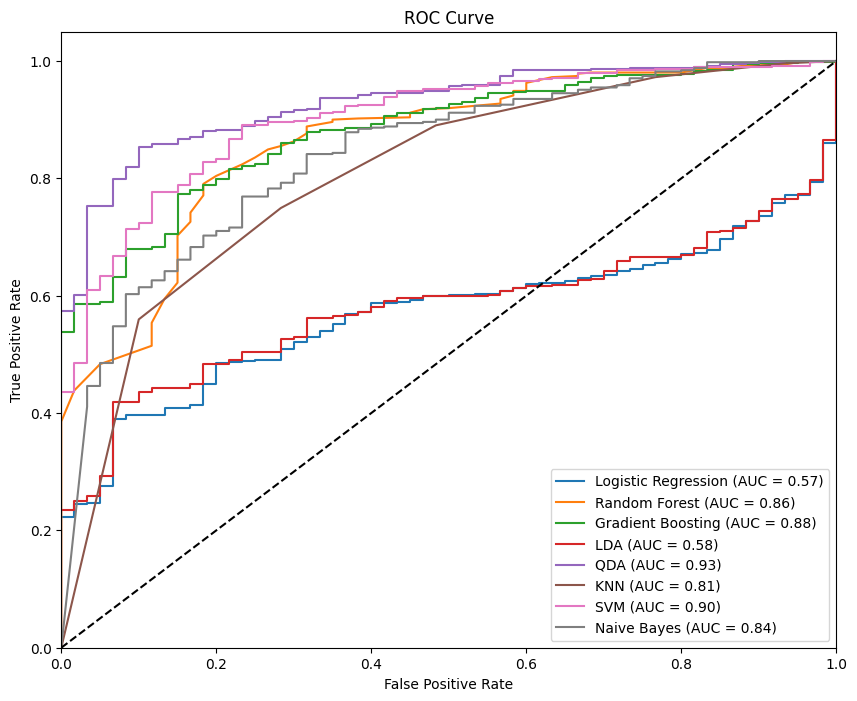

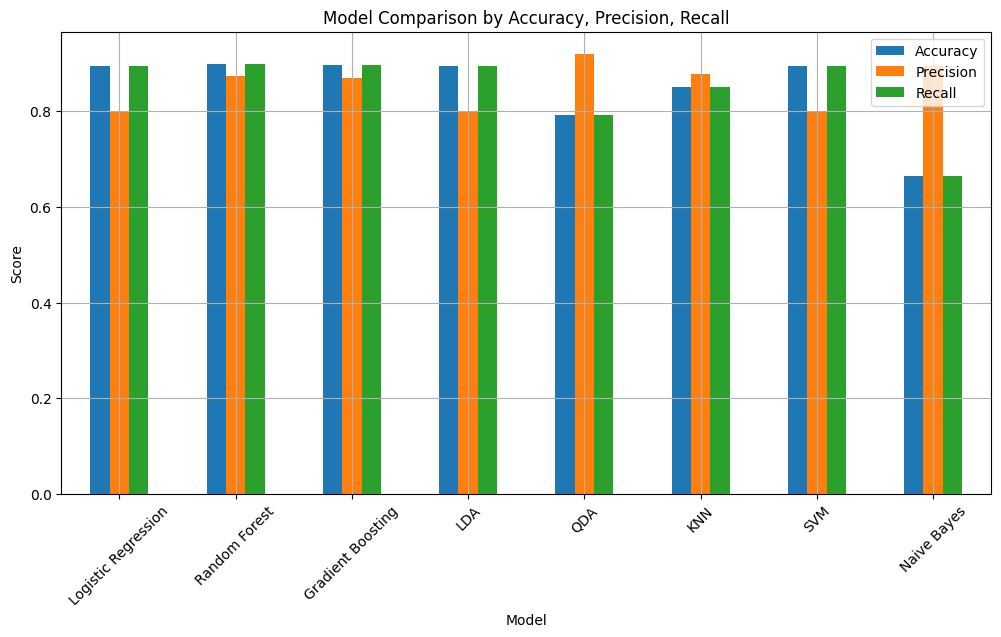

In [ ]:
models(grouped)